# Titanic - Machine Learning from Disaster

The version 2 is an experimental version. I was trying to play a little with other feature and with the parameters of the learning algorithm.
This version achieves a score of 0.78 in the kaggle's test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Define train and test dataframe

In [2]:
# Define train and test dataframe.
train_df = pd.read_csv('train.csv', sep=',')
test_df = pd.read_csv('test.csv', sep=',')

# Drop id col, we don't need it.
#train_df = train_df.drop(columns=["PassengerId"], axis=1)

print("Train dataset shape =", train_df.shape)
print(train_df.describe())

print("\nTest dataset shape =", test_df.shape)
print(test_df.describe())

Train dataset shape = (891, 12)
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

Test dataset shape = (418, 11)
       PassengerI

In [3]:
print("First 10 samples in the train dataframe:\n\n", train_df.head(10))

First 10 samples in the train dataframe:

    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                    

## Explore train dataset

In [4]:
# Print distribution split by survival.
def distrib_split_by_survival(df, col_name):
    # Split into survived/not survived
    survived = df[df["Survived"] == 1][col_name].dropna()
    not_survived = df[df["Survived"] == 0][col_name].dropna()
    
    # Create a stacked histogram
    plt.figure(figsize=(10, 6))
    plt.hist([survived, not_survived], bins=30, stacked=True, color=['blue', 'red'], label=['Survived', "Did not survived"], edgecolor='black')
    
    # Add labels and title
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.title(f"{col_name} Distribution Split by Survival")
    plt.legend()
    plt.show()

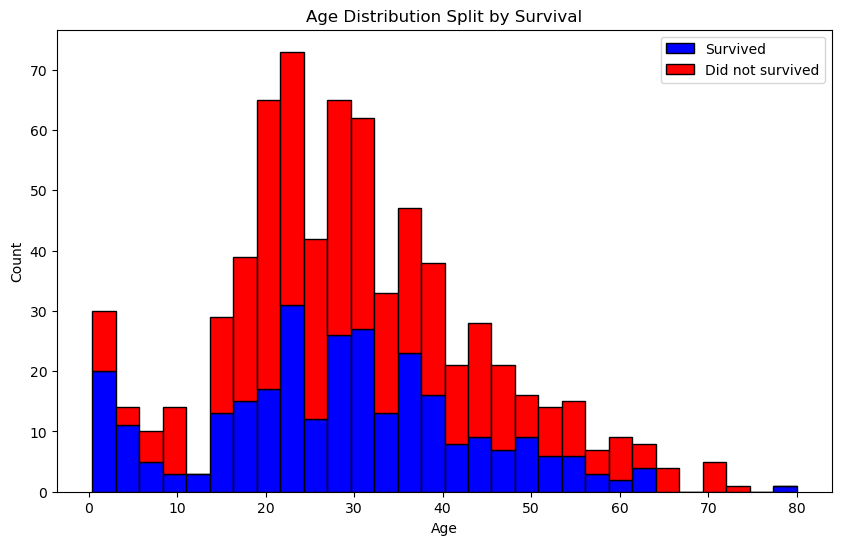

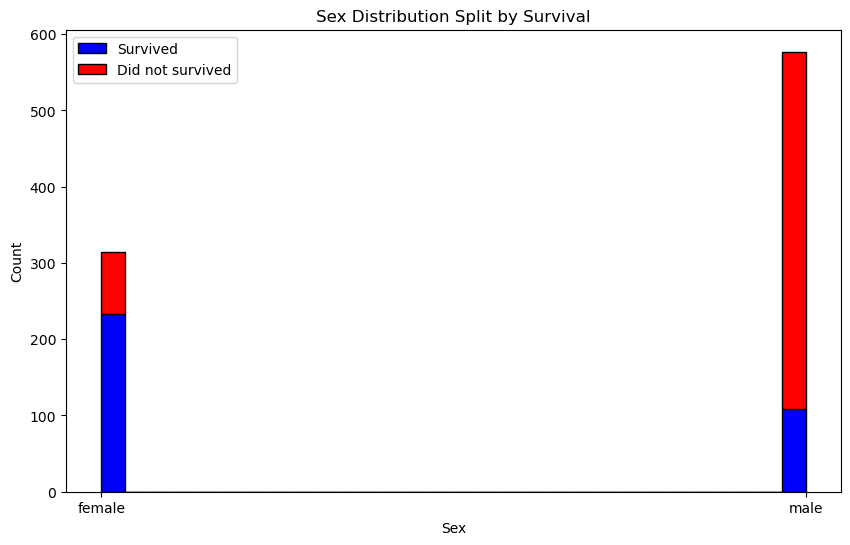

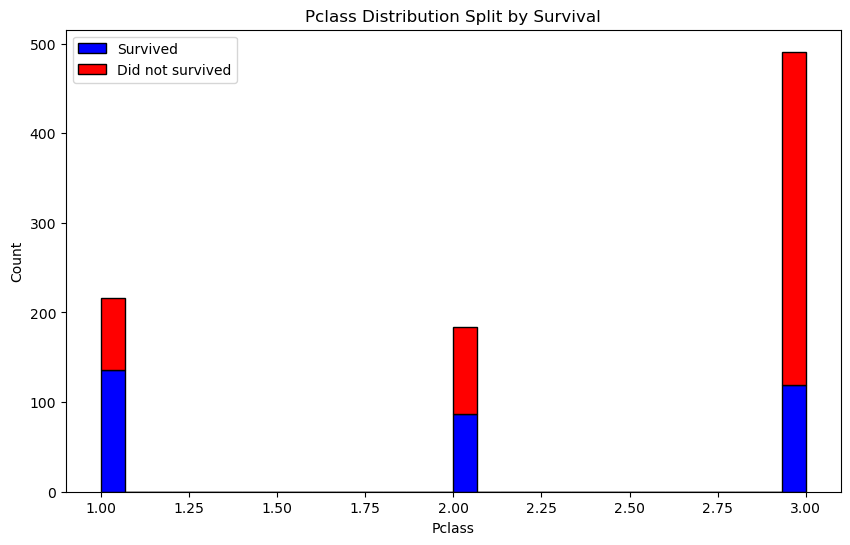

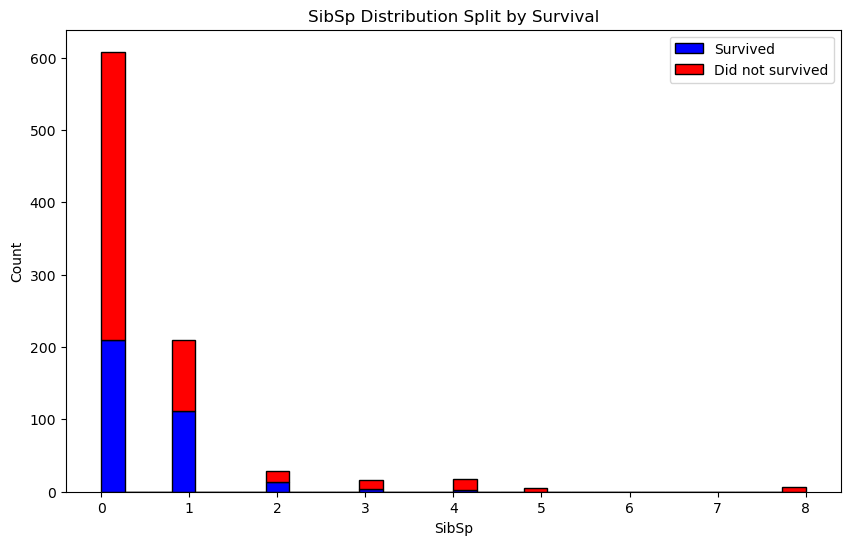

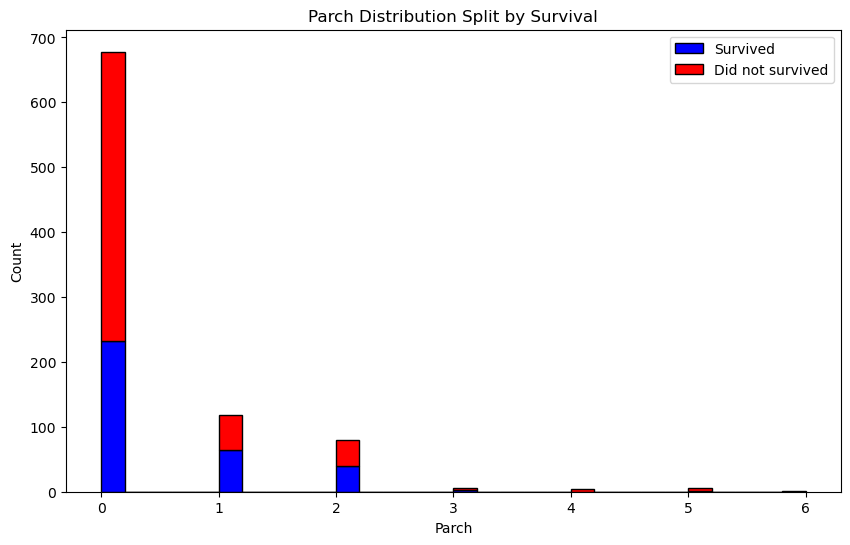

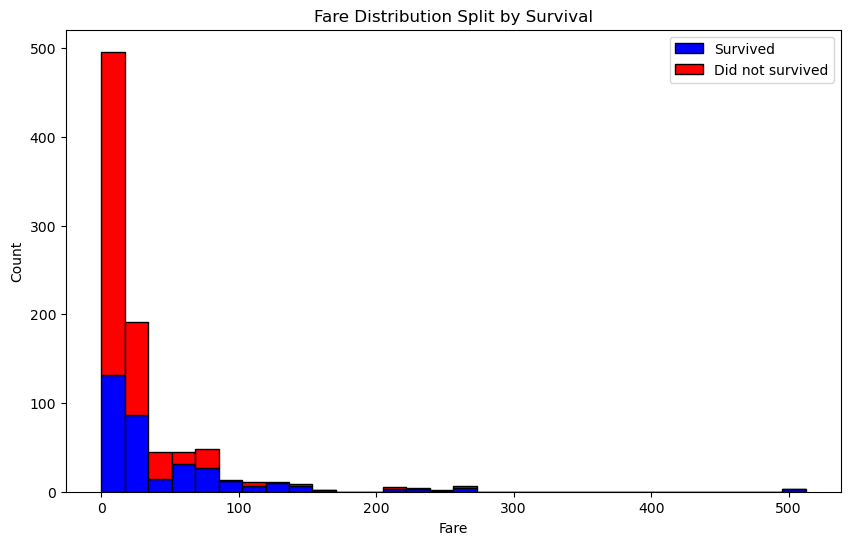

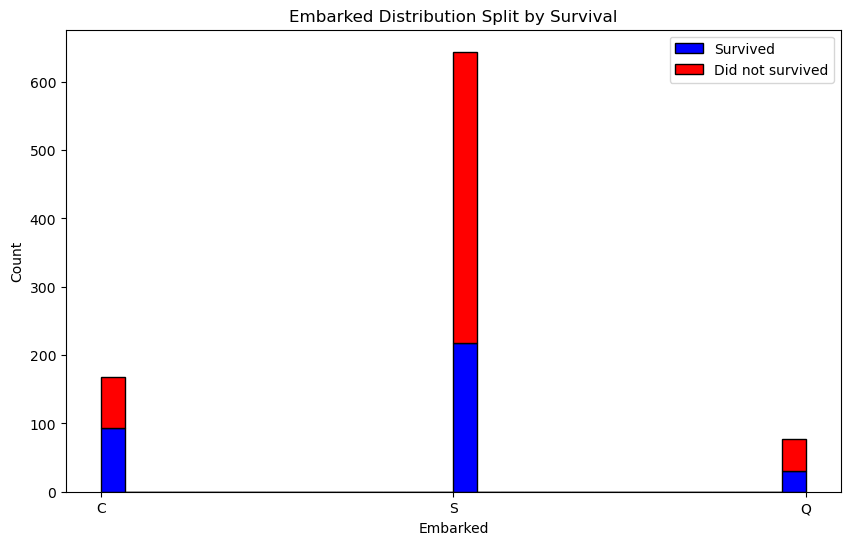

In [5]:
# Print Pclass distribution.
col_names = ["Age", "Sex", "Pclass", "SibSp", "Parch", "Fare", "Embarked"]
for cn in col_names:
    distrib_split_by_survival(train_df, cn)

## Deal with missing values

In [6]:
print("Train dataframe missing values:")
print(train_df.isna().sum())

print("\nTest dataframe missing values:")
print(test_df.isna().sum())

Train dataframe missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test dataframe missing values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Fill the missing values in Embarked col with the most frequent value, that is 'S'.
train_df["Embarked"] = train_df["Embarked"].fillna('S')

# Fill the missing value in Fare col with the mean.
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].mean())

## Feature engeenering

### Title

In [8]:
# Define a new column called title.
def get_title(name):
    if 'Sir.' in name:
        return 'High'
    elif 'Dr.' in name:
        return 'High'
    elif 'Mr.' in name:
        return 'Mr'
    elif 'Lady' in name:
        return 'High'
    elif 'Countess' in name:
        return 'High'
    elif 'Capt' in name:
        return 'High'
    elif 'Major' in name:
        return 'High'
    elif 'Jonkheer' in name:
        return 'High'
    elif 'Rev' in name:
        return 'High'
    elif 'Col' in name:
        return 'High'
    elif 'Don' in name:
        return 'High'
    elif 'Master' in name:
        return 'Master'
    elif 'Mrs.' in name:
        return 'Mrs'
    elif 'Ms.' in name:
        return 'Mrs'
    elif 'Miss.' in name:
        return 'Miss'
    else:
        return 'N'

# Train dataframe.
title_col = train_df['Name'].apply(get_title)
train_df["Title"] = title_col
print(title_col.value_counts())

# Test dataframe.
test_df["Title"] = test_df['Name'].apply(get_title)

Name
Mr        517
Miss      181
Mrs       125
Master     40
High       25
N           3
Name: count, dtype: int64


### Cabin

In [9]:
# Categorize cabin: take the first letter as new cabin value.
def first_cabin_letter(cabin):
    cabin = str(cabin)
    if cabin == "nan":
        return "FakeCabin"
    return cabin[0]

# Train dataframe.
new_cabin_col = train_df["Cabin"].apply(first_cabin_letter)
train_df["Cabin"] = new_cabin_col
print(new_cabin_col.value_counts())

# Test dataframe.
test_df["Cabin"] = test_df["Cabin"].apply(first_cabin_letter)

Cabin
FakeCabin    687
C             59
B             47
D             33
E             32
A             15
F             13
G              4
T              1
Name: count, dtype: int64


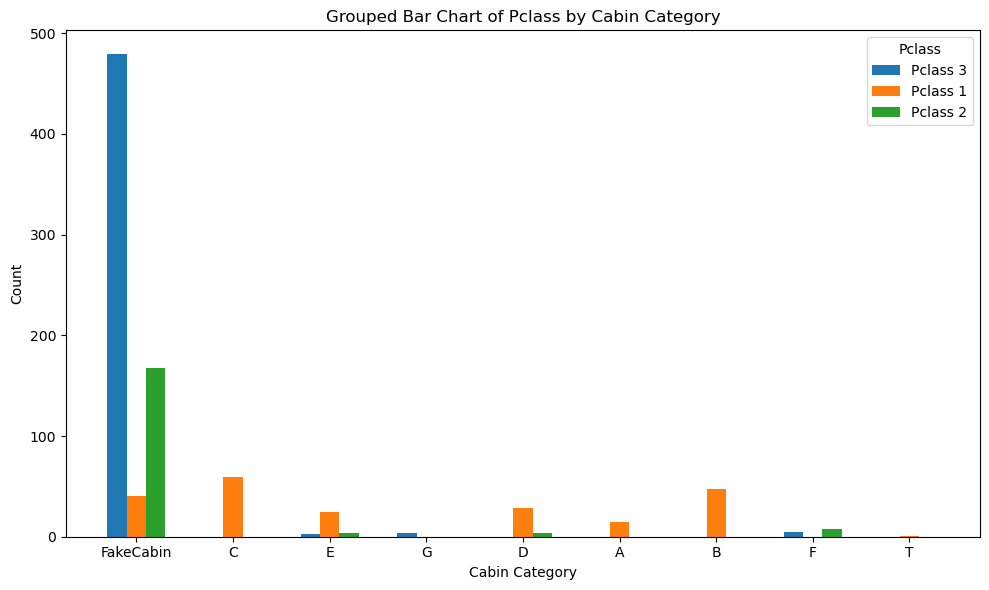

In [10]:
# Print class for each cabin category.
# Categories and classes.
category = train_df["Cabin"].unique()
classes = train_df["Pclass"].unique()

# Count occurrences of each class for each cabin category
counts = {cabin: [len(train_df[(train_df["Cabin"] == cabin) & (train_df["Pclass"] == cls)]) for cls in classes] for cabin in category}

# Create a grouped bar chart.
bar_width = 0.2
x = np.arange(len(category))  # x positions for the groups.

# Plot bars for each class.
plt.figure(figsize=(10, 6))
for i, cls in enumerate(classes):
    plt.bar(x + i * bar_width, [counts[cabin][i] for cabin in category], width=bar_width, label=f"Pclass {cls}")

plt.xticks(x + bar_width, category)  # Center group labels.
plt.xlabel("Cabin Category")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of Pclass by Cabin Category")
plt.legend(title="Pclass")

plt.tight_layout()
plt.show()

Since we have only one passenger in cabin T and since this passenger is in class 1, then we
add him in cabin A (which contains only passenger from class 1).

In [11]:
print(train_df[train_df["Cabin"] == "T"])
train_df.loc[train_df["Cabin"] == "T", "Cabin"] = "A"

     PassengerId  Survived  Pclass                          Name   Sex   Age  \
339          340         0       1  Blackwell, Mr. Stephen Weart  male  45.0   

     SibSp  Parch  Ticket  Fare Cabin Embarked Title  
339      0      0  113784  35.5     T        S    Mr  


### Family size

Family size = SibSp + Parch

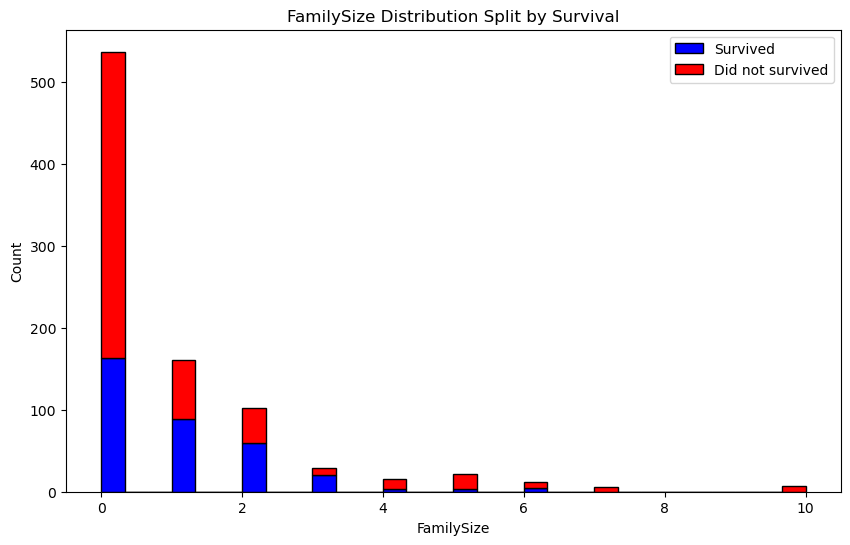

In [12]:
# Add new column called FamilySize.
train_df["FamilySize"] = train_df["Parch"] + train_df["SibSp"]
test_df["FamilySize"] = test_df["Parch"] + test_df["SibSp"]
distrib_split_by_survival(train_df, "FamilySize")

In [13]:
# We can just drop the SibSp and Parch cols.
train_df = train_df.drop(columns=["SibSp", "Parch"], axis=1)
test_df = test_df.drop(columns=["SibSp", "Parch"], axis=1)

## Family name and ticket

In [14]:
def get_family_name(name):
    return name.split()[0]

# Train dataframe.
family_name_col = train_df["Name"].apply(get_family_name)
print(family_name_col.value_counts())
train_df["FamilyName"] = family_name_col

# Test dataframe.
test_df["FamilyName"] = test_df["Name"].apply(get_family_name)

Name
Andersson,      9
Sage,           7
Johnson,        6
Panula,         6
Skoog,          6
               ..
Spedden,        1
Dennis,         1
Danoff,         1
Slayter,        1
Francatelli,    1
Name: count, Length: 661, dtype: int64


In [15]:
def clean_ticket(ticket):
    if ticket == "LINE":
        return -1 # Fake ticket
    return int(ticket.split()[-1])

# Train dataframe.
#print(train_df[train_df["Ticket"] == "LINE"])
new_ticket_col = train_df["Ticket"].apply(clean_ticket)
train_df["Ticket"] = new_ticket_col

# Test dataframe.
test_df["Ticket"] = test_df["Ticket"].apply(clean_ticket)

In [16]:
# Train dataframe.
from itertools import combinations

def assign_family_id(group):
    group = group.sort_values(by="Ticket").reset_index(drop=True)
    family_ids = [-1] * len(group)  # Temporary values for FamilyId
    current_group = 0
    
    # Iterate over pairs and assign the same FamilyId if the condition holds
    for i, j in combinations(range(len(group)), 2):
        if abs(group.loc[i, "Ticket"] - group.loc[j, "Ticket"]) < 50:
            if family_ids[i] == -1 and family_ids[j] == -1:
                # Assign the FamilyId as the PassengerId of the first matched row
                family_ids[i] = family_ids[j] = group.loc[i, "PassengerId"]
            elif family_ids[i] == -1:
                family_ids[i] = family_ids[j]
            elif family_ids[j] == -1:
                family_ids[j] = family_ids[i]

    # Ensure that each passenger who wasn't assigned gets a unique FamilyId (if isolated)
    for idx in range(len(group)):
        if family_ids[idx] == -1:
            family_ids[idx] = 0

    group["FamilyId"] = family_ids
    return group


train_df = train_df.groupby("FamilyName", group_keys=False).apply(assign_family_id)
print(train_df["FamilyId"].value_counts())
train_df = train_df.drop(columns="FamilyName", axis=1)

FamilyId
0      601
14       7
160      7
60       6
51       6
      ... 
103      2
319      2
621      2
112      2
287      2
Name: count, Length: 116, dtype: int64


/tmp/ipykernel_6132/80144732.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("FamilyName", group_keys=False).apply(assign_family_id)


In [17]:
# Test dataframe.
def assign_family_id(group):
    group = group.sort_values(by="Ticket").reset_index(drop=True)
    family_ids = [-1] * len(group)  # Temporary values for FamilyId
    current_group = 0
    
    # Iterate over pairs and assign the same FamilyId if the condition holds
    for i, j in combinations(range(len(group)), 2):
        if abs(group.loc[i, "Ticket"] - group.loc[j, "Ticket"]) < 50:
            if family_ids[i] == -1 and family_ids[j] == -1:
                # Assign the FamilyId as the PassengerId of the first matched row
                family_ids[i] = family_ids[j] = group.loc[i, "PassengerId"]
            elif family_ids[i] == -1:
                family_ids[i] = family_ids[j]
            elif family_ids[j] == -1:
                family_ids[j] = family_ids[i]

    # Ensure that each passenger who wasn't assigned gets a unique FamilyId (if isolated)
    for idx in range(len(group)):
        if family_ids[idx] == -1:
            family_ids[idx] = 0

    group["FamilyId"] = family_ids
    return group

test_df = test_df.groupby("FamilyName", group_keys=False).apply(assign_family_id)
test_df = test_df.drop(columns="FamilyName", axis=1)

/tmp/ipykernel_6132/1459966223.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("FamilyName", group_keys=False).apply(assign_family_id)


### Categorize Fare

In [18]:
def categ_fare(fare):
    if fare <= 10:
        return "Very low"
    elif fare <= 30:
        return "Low"
    elif fare <= 70:
        return "Mid"
    elif fare <= 120:
        return "High"
    else:
        return "Very high"

# Train dataframe.
new_fare_col = train_df["Fare"].apply(categ_fare)
print(new_fare_col.value_counts())
train_df["Fare"] = new_fare_col

# Test dataframe.
test_df["Fare"] = test_df["Fare"].apply(categ_fare)

Fare
Very low     336
Low          321
Mid          129
High          67
Very high     38
Name: count, dtype: int64


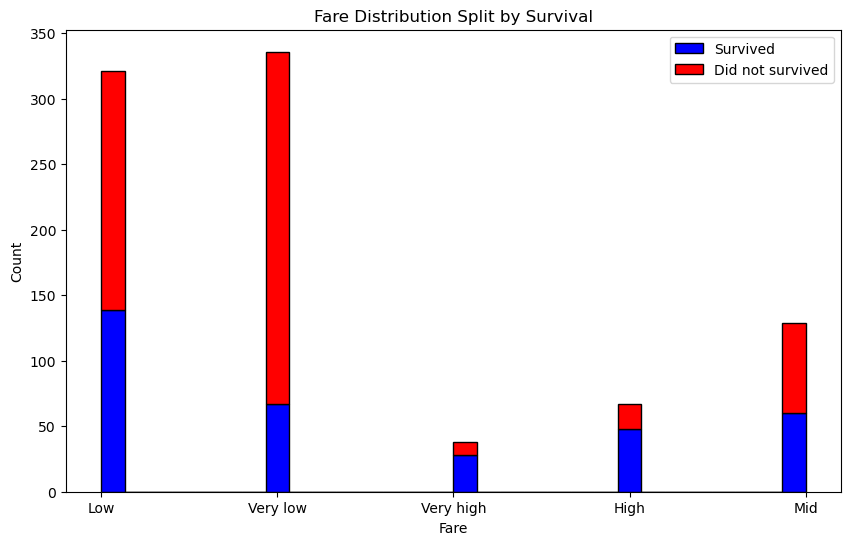

In [19]:
distrib_split_by_survival(train_df, "Fare")

### Drop Name, Ticket and ID

In [20]:
train_df = train_df.drop(columns=["PassengerId", "Name", "Ticket"], axis=1)
test_df = test_df.drop(columns=["Name", "Ticket"], axis=1)

### Age

Since age is a very important feature and in both train and test dataframes we're missing many values, we can try something differen.

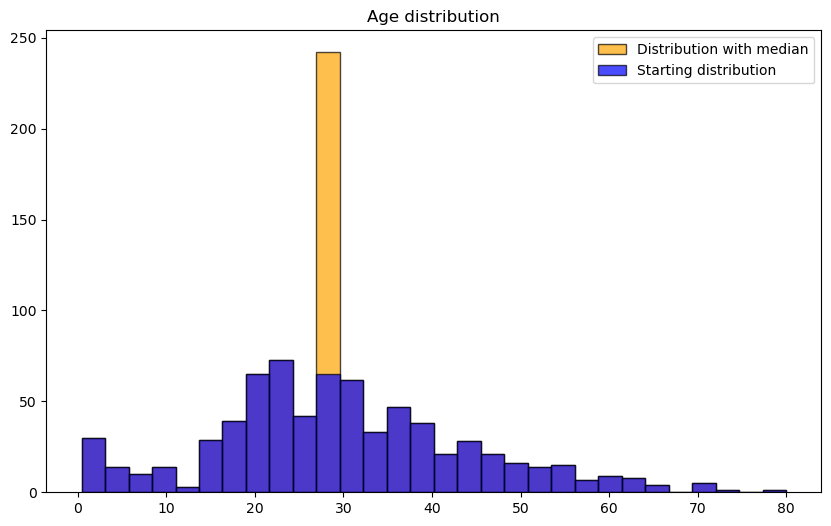

In [21]:
# Try with the median.
median_age_col = train_df['Age'].fillna(train_df['Age'].median())
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(median_age_col.tolist(), bins=30, color='orange', alpha=0.7, edgecolor='black', label="Distribution with median")
plt.hist(train_df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Starting distribution")
plt.title("Age distribution")
plt.legend()
plt.show()

Instead of using the median, we will train (in the following sections) a Decision Tree model.

## Encode categorical features

In [22]:
# Matrix with instances.
X_train = train_df.dropna().drop(columns=["Survived"], axis=1)
X_test = test_df.dropna()
# Vector with labels.
Y_train = train_df.dropna()["Survived"]

print("Tot number of samples in train set:", X_train.shape[0])
features_names = list(X_train.columns)
print("Features names:", features_names)

X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values

Tot number of samples in train set: 714
Features names: ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'FamilyId']


In [23]:
# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'str'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'str'>
Column Cabin (index: 4) -- data type: <class 'str'>
Column Embarked (index: 5) -- data type: <class 'str'>
Column Title (index: 6) -- data type: <class 'str'>
Column FamilySize (index: 7) -- data type: <class 'int'>
Column FamilyId (index: 8) -- data type: <class 'int'>


In [24]:
# Encode the categorical variables: Sex, Cabin, Embarked, Title.
to_encode = np.array([1, 3, 4, 5, 6])

enc = OrdinalEncoder() # Encoder.

enc.fit(X_train[:, to_encode])
X_train[:, to_encode] = enc.transform(X_train[:, to_encode])
X_test[:, to_encode+1] = enc.transform(X_test[:, to_encode+1])

# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column Pclass (index: 0) -- data type: <class 'int'>
Column Sex (index: 1) -- data type: <class 'float'>
Column Age (index: 2) -- data type: <class 'float'>
Column Fare (index: 3) -- data type: <class 'float'>
Column Cabin (index: 4) -- data type: <class 'float'>
Column Embarked (index: 5) -- data type: <class 'float'>
Column Title (index: 6) -- data type: <class 'float'>
Column FamilySize (index: 7) -- data type: <class 'int'>
Column FamilyId (index: 8) -- data type: <class 'int'>


## Predict missing age values with Random Forest model

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Optimal param: {'max_depth': 5, 'random_state': 12}


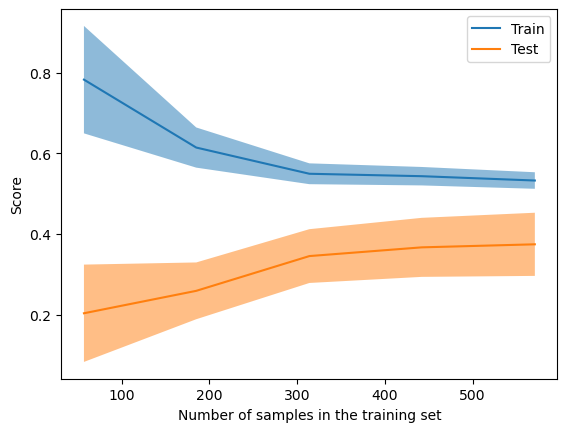

In [25]:
# Use k-cross validation.
X_age_train = X_train[:, [0, 1, 3, 4, 5, 6, 7, 8]]
Y_age_train = X_train[:, [2]]

# Search grid.
param_grid = {
    "max_depth": range(1, 10),
    "random_state": [12]
}

rf_gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=10, verbose=1)
rf_gs.fit(X_age_train, Y_age_train.ravel())
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_age_train, Y_age_train.ravel())

In [26]:
# Predict the missing age values.
to_predict = train_df[train_df["Age"].isna()].drop(columns=["Age", "Survived"], axis=1)
print(to_predict)
to_predict = to_predict.values

# Encode.
to_predict[:, [1, 2, 3, 4, 5]] = enc.transform(to_predict[:, [1, 2, 3, 4, 5]])

# Predict the age.
missing_age = rf_gs.best_estimator_.predict(to_predict)

    Pclass     Sex      Fare      Cabin Embarked Title  FamilySize  FamilyId
0        1    male       Low  FakeCabin        S    Mr           0         0
0        3    male  Very low  FakeCabin        C    Mr           0       599
1        3  female       Low  FakeCabin        C   Mrs           2       599
0        3  female  Very low  FakeCabin        Q  Miss           2       594
0        1    male       Low  FakeCabin        S    Mr           0         0
..     ...     ...       ...        ...      ...   ...         ...       ...
0        1    male       Mid          C        S    Mr           0         0
0        3    male  Very low  FakeCabin        C    Mr           0         0
0        3    male       Low  FakeCabin        C    Mr           0         0
1        3  female       Low  FakeCabin        C  Miss           1       112
1        3    male  Very low  FakeCabin        S    Mr           0         0

[177 rows x 8 columns]


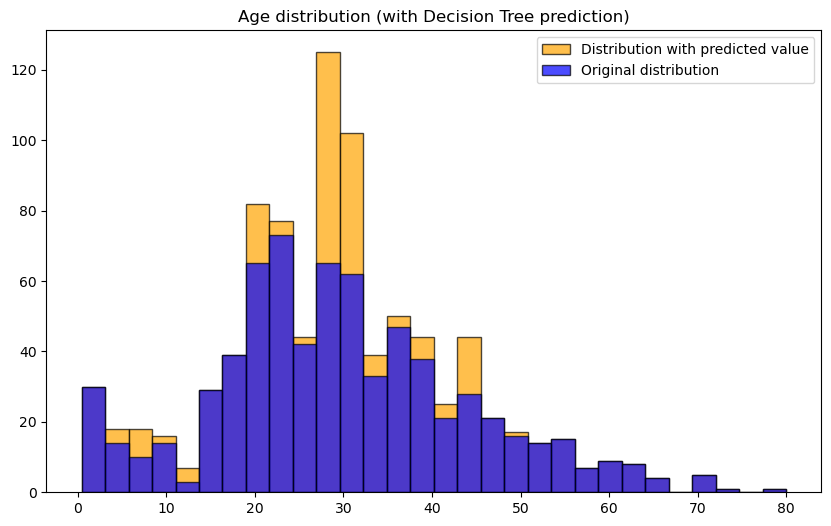

In [27]:
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(np.append(missing_age, X_train[:, 2]) , bins=30, color='orange', alpha=0.7, edgecolor='black', label="Distribution with predicted value")
plt.hist(X_train[:, 2], bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("Age distribution (with Decision Tree prediction)")
plt.legend()
plt.show()

In [28]:
# Now we add samples with the predicted value to the train set.
X_train = np.vstack((X_train, np.insert(to_predict, 2, missing_age, axis=1)))
Y_train = np.append(Y_train, train_df[train_df["Age"].isna()]["Survived"])
print(X_train.shape)
print(Y_train.shape)

(891, 9)
(891,)


In [29]:
# Predict the missing data values of the test set.
to_predict = test_df[test_df["Age"].isna()].drop(columns=["Age"], axis=1)
print(to_predict)
to_predict = to_predict.values

# Encode.
to_predict[:, [2, 3, 4, 5, 6]] = enc.transform(to_predict[:, [2, 3, 4, 5, 6]])

# Predict the age.
missing_age = rf_gs.best_estimator_.predict(to_predict[:, 1:])

# Add the samples with the predicted value to the test set.
X_test = np.vstack((X_test, np.insert(to_predict, 3, missing_age, axis=1)))
print(X_test.shape)

    PassengerId  Pclass     Sex      Fare      Cabin Embarked   Title  \
0          1231       3    male  Very low  FakeCabin        C  Master   
0          1258       3    male       Low  FakeCabin        C      Mr   
0          1060       1  female       Low  FakeCabin        C     Mrs   
0          1158       1    male  Very low  FakeCabin        S      Mr   
0           957       2  female       Low  FakeCabin        S     Mrs   
..          ...     ...     ...       ...        ...      ...     ...   
3          1308       3    male  Very low  FakeCabin        S      Mr   
0          1159       3    male  Very low  FakeCabin        S      Mr   
0          1276       2    male       Low  FakeCabin        S      Mr   
0          1000       3    male  Very low  FakeCabin        S      Mr   
1          1236       3    male       Low  FakeCabin        S  Master   

    FamilySize  FamilyId  
0            0         0  
0            1         0  
0            0         0  
0            0 

### Categorize Age

In [30]:
def categ_age(age):
    if age <= 12:
        return "Child"
    elif age <= 20:
        return "Teenager"
    elif age <= 30:
        return "Young adult"
    elif age <= 60:
        return "Adult"
    else:
        return "Elderly"

# Train dataframe.
new_age_col = []
for row in X_train:
    new_age_col.append(categ_age(row[2]))
print(pd.DataFrame(new_age_col).value_counts())
for i, c_age in enumerate(new_age_col):
    X_train[i, 2] = c_age

enc.fit(X_train[:, [2]])
X_train[:, [2]] = enc.transform(X_train[:, [2]])
    
# Test dataframe.
for i in range(X_test.shape[0]):
    X_test[i, 3] = categ_age(X_test[i, 3])
X_test[:, [3]] = enc.transform(X_test[:, [3]])

0          
Adult          356
Young adult    316
Teenager       110
Child           87
Elderly         22
Name: count, dtype: int64


## Split train dataframe into train and validation set.

In [31]:
m = X_train.shape[0]
m_train = int(4./5. * m)
m_val = m - m_train

print("Amount of data for training set:", m_train)
print("Amount of data for validation set", m_val)

# Split into train and validation.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=m_val/m, random_state=12)

# Check size of sets.
print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])

Amount of data for training set: 712
Amount of data for validation set 179
Training size: 712
Validation size: 179


## Standardize data

In [32]:
# Standardize age and fare columns.
to_scale = np.array([8])

# Create a copy for each set.
X_train_scaled = np.copy(X_train)
X_val_scaled = np.copy(X_val)
X_test_scaled = np.copy(X_test)

# Scale data.
scaler = StandardScaler().fit(X_train[:, to_scale])
X_train_scaled[:, to_scale] = scaler.transform(X_train[:, to_scale])
X_val_scaled[:, to_scale] = scaler.transform(X_val[:, to_scale])
X_test_scaled[:, to_scale+1] = scaler.transform(X_test[:, to_scale+1])

## Train Random Forest model

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=-1, random_state=12; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=-1, random_state=12; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=-1, random_state=12; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=-1, random_state=12; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=-1, random_state=12; total time=   0.1s
[CV] END bootstrap=True, cri

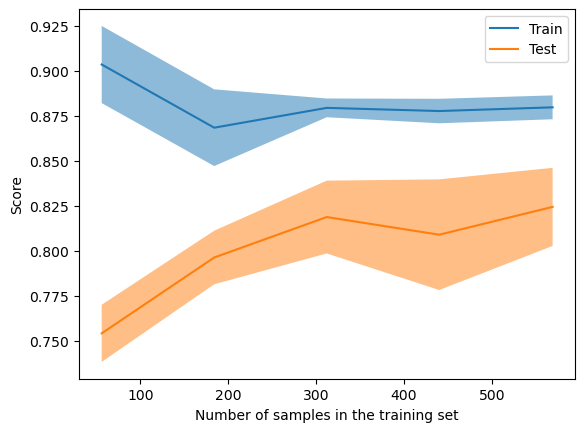

In [36]:
# Find best value for max depth.
param_grid = {
    "max_depth": [v for v in range(1, 10)], 
    "random_state": [12]
}

param_grid = {
    "n_estimators": [50, 100, 200, 300],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required at a leaf node
    "max_features": ["sqrt", "log2"],  # Number of features to consider at each split
    "bootstrap": [True, False],  # Whether to use bootstrap samples
    "criterion": ["gini", "entropy"],  # Split criteria
    "n_jobs": [-1],
    "random_state": [12]  # Fixed seed for reproducibility
}

rf_gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=2)
rf_gs.fit(X_train_scaled, Y_train)
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_train_scaled, Y_train)

In [37]:
print("Validation score:", rf_gs.best_estimator_.score(X_val_scaled, Y_val))

Validation score: 0.8324022346368715


## Create submission

In [ ]:
# Compute predictions.
predictions = rf_gs.best_estimator_.predict(X_test[:, 1:])

# Save predictions.
output = pd.DataFrame({'PassengerId': X_test[:, [0]].flatten(), 'Survived': predictions}) 
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")